# 01_simulation.ipynb

This notebook demonstrates how to use your `ResistanceSimulator` and `PhenotypeHelper` modules to generate and inspect simulated data.


### 1. Setup & Imports

In [2]:
import os, sys
sys.path.append(os.path.abspath("../src"))

import pandas as pd
import xarray as xr

from data.simulation import ResistanceSimulator
from utils.phenotype_utils import PhenotypeHelper


### 2. Initialize Simulator & Fetch Genotypes

In [3]:
sim = ResistanceSimulator()

# Fetch L995F and Ace1 variant genotypes
g1, var1 = sim.fetch_variant("2L:2438000-2439000", 2438000)
g2, var2 = sim.fetch_variant("2R:3484107-3495790", 3484107)

print("Variants:", var1, var2)

Variants: random_variant random_variant


### 3. Combine SNP Data

In [4]:
geno_ds = sim.combine_snp_data(g1, g2)
geno_ds

<xarray.Dataset>
Dimensions:           (samples: 22605, variants: 2)
Coordinates:
  * samples           (samples) <U29 'VBS00256-4651STDY7017184' ... 'SAMN1522...
  * variants          (variants) <U16 'VGSC_L995F_proxy' 'Ace1_RDL_proxy'
    variant_position  (variants) int32 2438000 3484107
    variant_contig    (variants) <U2 '2L' '2R'
Data variables:
    call_genotype     (samples, variants) int32 1 2 1 1 2 1 2 ... 0 0 0 0 1 1 1

### 4. Simulate Phenotypes

<Axes: >

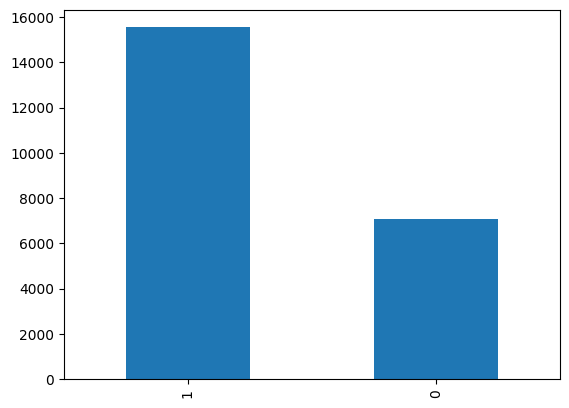

In [5]:
pheno_series = sim.simulate_phenotypes(g1, g2)
pheno_series.value_counts().plot.bar()

### 5. Build Final Xarray Dataset

In [6]:
# Build a DataFrame from the Series
df_pheno = sim.create_phenotype_df(pheno_series)

# Merge with variant dataset
final_ds = PhenotypeHelper.create_dataset(df_pheno, variant_data=geno_ds)
final_ds

<xarray.Dataset>
Dimensions:           (samples: 22605, variants: 2)
Coordinates:
  * samples           (samples) object 'VBS57510-6411STDY12305729' ... 'VBS19...
  * variants          (variants) <U16 'VGSC_L995F_proxy' 'Ace1_RDL_proxy'
    variant_position  (variants) int32 2438000 3484107
    variant_contig    (variants) <U2 '2L' '2R'
Data variables:
    phenotype_binary  (samples) float64 0.0 1.0 1.0 1.0 1.0 ... 0.0 1.0 0.0 0.0
    phenotype         (samples) object 'susceptible' ... 'susceptible'
    insecticide       (samples) object 'simulated_insecticide' ... 'simulated...
    dose              (samples) object 'simulated_dose' ... 'simulated_dose'
    call_genotype     (samples, variants) int32 0 2 1 0 0 2 2 ... 0 1 2 0 1 2 0

### 6. Quick Summaries

In [12]:
# Ensure phenotype series has a proper name for the column
pheno_series_named = pheno_series.rename("phenotype_binary")

# Join metadata and phenotype series
meta = sim.meta.set_index("sample_id")
res_by_country = pd.concat([meta["country"], pheno_series_named], axis=1)

# Group by country and compute mean resistance
avg_resistance_by_country = res_by_country.groupby("country")["phenotype_binary"].mean()

print(avg_resistance_by_country)


country
Angola                              0.707865
Benin                               0.703170
Burkina Faso                        0.735751
Cameroon                            0.673964
Central African Republic            0.671233
Comoros, The Union of the           0.771429
Cote d'Ivoire                       0.688129
Democratic Republic of the Congo    0.683578
Equatorial Guinea                   0.789474
Ethiopia                            0.675056
Gabon                               0.681648
Gambia, The                         0.683017
Ghana                               0.748220
Guinea                              0.659306
Guinea-Bissau                       0.721739
Kenya                               0.714504
Lab Cross                           0.673401
Madagascar                          0.600000
Malawi                              0.804878
Mali                                0.579176
Mayotte                             0.826087
Mozambique                          0.743243
Ni

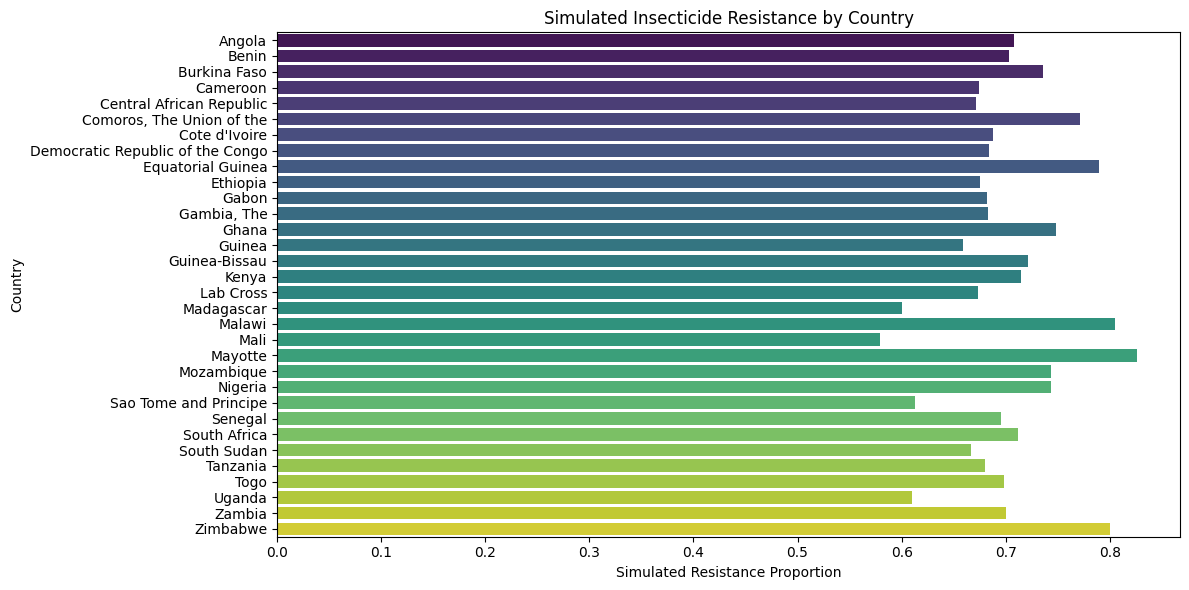

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(x=avg_resistance_by_country.values, y=avg_resistance_by_country.index, palette="viridis")
plt.xlabel("Simulated Resistance Proportion")
plt.ylabel("Country")
plt.title("Simulated Insecticide Resistance by Country")
plt.tight_layout()
plt.show()
